In [1]:
%pylab inline
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid_at_node
from landlab.components import PresFlowNetwork, MeltCreep
import numpy as np
from matplotlib import colors,  cm
import matplotlib.animation as animation
from landlab.components.conduit_networks.calcite import calcite_diss_palmer_transfer

from PIL import Image
from PIL import ImageDraw

def plot_links(grid, value_name, autoscale=True, 
               vmin=0., vmax=0., cmap_name='viridis', 
               magnitude= False, lw=5, 
               pixels_per_node=31, x_name='X', 
               y_name='Y', var_name='', use_PIL=True):#, logvalues=False ):
    if use_PIL:
        pixel_xscaling_factor = pixels_per_node/grid.dx
        pixel_yscaling_factor = pixels_per_node/grid.dy
        im = Image.new('RGBA', ( int(round(grid.number_of_cell_columns*pixels_per_node)), int(round(grid.number_of_cell_rows*pixels_per_node)) ), (255,255,255,255))
        draw = ImageDraw.Draw(im)

    link_head_x = grid.node_x[grid.node_at_link_head]
    link_head_y = grid.node_y[grid.node_at_link_head]
    link_tail_x = grid.node_x[grid.node_at_link_tail]
    link_tail_y = grid.node_y[grid.node_at_link_tail]       
    if magnitude:
        values = abs(grid.at_link[value_name])
    else:
        values = grid.at_link[value_name]
    #if logvalues:
    #    values = np.log10(abs(grid.at_link[value_name]))
    
    
    
    #Normalize color values
    if autoscale:
        cnorm = colors.Normalize()
        cnorm.autoscale(values)
    else:
        cnorm = colors.Normalize(vmin,vmax)
    scalarMap = cm.ScalarMappable(norm=cnorm, cmap = get_cmap(cmap_name))
    scalarMap.set_array(values)
    #set_cmap()
    if use_PIL:
        for i, value in enumerate(values):
            draw.line( ((link_head_x[i]*pixel_xscaling_factor,link_head_y[i]*pixel_yscaling_factor),(link_tail_x[i]*pixel_xscaling_factor,link_tail_y[i]*pixel_yscaling_factor)),fill=scalarMap.to_rgba(value,bytes=True),width=lw) 
        imshow(np.asarray(im), origin='lower', extent=(0,grid.number_of_cell_columns,0,grid.number_of_cell_rows))
    else:
        for i, value in enumerate(values):
            xs = [link_head_x[i],link_tail_x[i]]
            ys = [link_head_y[i],link_tail_y[i]]
            img = plot(xs,ys,lw=lw,color=scalarMap.to_rgba(value))    
    cb = colorbar(scalarMap)
    cb.ax.set_ylabel(var_name)
    xlabel(x_name)
    ylabel(y_name)


Populating the interactive namespace from numpy and matplotlib


In [7]:
mg = RasterModelGrid((5,5),100)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')
mg.add_zeros('node','storage')
mg.at_node['storage']=10.*np.ones(mg.number_of_nodes)

mg.at_node['junction__elevation'] = -0.01*mg.node_x + 4.


w = mg.add_zeros('link','width')
mg.at_link['width']= 0.5*np.ones(mg.number_of_links)#.*np.random.rand(mg.number_of_active_links)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'] = w

#mg.at_node['input__discharge'][12]=0.5

#Set up link elevation offsets
xc_min_head = mg.add_zeros('link', 'conduit_head__offset')
xc_min_tail = mg.add_zeros('link', 'conduit_tail__offset')
y_max = mg.add_zeros('link', 'maximum__depth')
mg.at_link['maximum__depth']= mg.at_link['hydraulic__diameter']#applicable for square conduits



#set heads at edges
h[mg.nodes_at_left_edge] = 4.2
h[mg.nodes_at_right_edge] = 0
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.

mg.set_closed_boundaries_at_grid_edges(False,True,False,True)
Q[mg.active_links] = 0.#0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)


pfn = PresFlowNetwork(mg)


Number of links =  40
Number of nodes =  25
Number of active links =  18
Number of core nodes =  9


In [8]:
pfn.dyn_wave_solution(dt=50.)

y= [  1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 0.0
y= [  2.49999200e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   2.49999200e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   2.49999200e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 0.0
max change in h:  3.94718378906e-11
average dh= 4.29188020821e-06   average abs(dQ)= 1.26091085403e-11


In [9]:
mg.calc_net_flux_at_node(Q)[mg.core_nodes]/mg.dx

array([  5.15022467e-06,   3.15774703e-11,   0.00000000e+00,
         5.15022467e-06,   3.15774703e-11,   0.00000000e+00,
         5.15022467e-06,   3.15774703e-11,   0.00000000e+00])

In [13]:
for i in arange(500):
    print('Time iteration:', i)
    pfn.dyn_wave_solution(dt=500.)

Time iteration: 0
y= [ 0.26249801  0.23216578  0.28541584  0.21574858  0.32499602  0.13933553
  0.43149615  0.26249801  0.23216578  0.28541584  0.21574858  0.32499602
  0.13933553  0.43149615  0.26249801  0.23216578  0.28541584  0.21574858]
max h_old= 4.2
max Q_old = 0.0
y= [ 0.26508991  0.23552093  0.28322354  0.21279302  0.33017983  0.14086203
  0.42558505  0.26508991  0.23552093  0.28322354  0.21279302  0.33017983
  0.14086203  0.42558505  0.26508991  0.23552093  0.28322354  0.21279302]
max h_old= 4.2
max Q_old = 0.0
max change in h:  0.0372921370442
y= [ 0.25834434  0.24742143  0.31172347  0.22264689  0.31668868  0.17815417
  0.44529278  0.25834434  0.24742143  0.31172347  0.22264689  0.31668868
  0.17815417  0.44529278  0.25834434  0.24742143  0.31172347  0.22264689]
max h_old= 4.2
max Q_old = 0.0
max change in h:  0.129201463309
y= [ 0.20494805  0.12512003  0.29764256  0.23553245  0.2098961   0.04034396
  0.57449424  0.20494805  0.12512003  0.29764256  0.23553245  0.2098961
  0.0

y= [  1.00000500e-01   1.00000000e-06   2.51162982e-01   1.14996260e-05
   1.00000000e-06   1.00000000e-06   6.39946245e-05   1.00000500e-01
   1.00000000e-06   2.51162982e-01   1.14996260e-05   1.00000000e-06
   1.00000000e-06   6.39946245e-05   1.00000500e-01   1.00000000e-06
   2.51162982e-01   1.14996260e-05]
max h_old= 7.03061768349
max Q_old = 0.376816447959
max change in h:  19.0738809988
y= [  1.00000500e-01   2.49999200e-06   2.50580642e-01   1.00000000e-06
   1.00000000e-06   3.99998400e-06   1.00000000e-06   1.00000500e-01
   2.49999200e-06   2.50580642e-01   1.00000000e-06   1.00000000e-06
   3.99998400e-06   1.00000000e-06   1.00000500e-01   2.49999200e-06
   2.50580642e-01   1.00000000e-06]
max h_old= 7.03061768349
max Q_old = 0.376816447959
max change in h:  3.50911679788
y= [  2.42857653e-01   9.99986800e-06   2.50290484e-01   1.00000000e-06
   3.99998400e-06   1.59996800e-05   1.00000000e-06   2.42857653e-01
   9.99986800e-06   2.50290484e-01   1.00000000e-06   3.99998

max change in h:  7.9028566639
y= [  1.50952762e-01   3.99998400e-06   5.00001001e-01   2.34981941e-05
   3.99998400e-06   3.99998400e-06   2.55912990e-04   1.50952762e-01
   3.99998400e-06   5.00001001e-01   2.34981941e-05   3.99998400e-06
   3.99998400e-06   2.55912990e-04   1.50952762e-01   3.99998400e-06
   5.00001001e-01   2.34981941e-05]
max h_old= 7.64182030285
max Q_old = 0.12153138895
max change in h:  0.357380999404
y= [  1.20642242e-01   1.59996800e-05   5.00000000e-01   4.74919714e-05
   1.59996800e-05   1.59996800e-05   1.02260517e-03   1.20642242e-01
   1.59996800e-05   5.00000000e-01   4.74919714e-05   1.59996800e-05
   1.59996800e-05   1.02260517e-03   1.20642242e-01   1.59996800e-05
   5.00000000e-01   4.74919714e-05]
max h_old= 7.64182030285
max Q_old = 0.12153138895
max change in h:  2.63448608734
y= [  1.00000500e-01   1.00000000e-06   2.50000500e-01   9.54659023e-05
   1.00000000e-06   1.00000000e-06   4.07375729e-03   1.00000500e-01
   1.00000000e-06   2.50000500e

max change in h:  7.59593462783
y= [  1.78781593e-01   5.49993400e-06   2.50980087e-01   2.49999200e-06
   3.99998400e-06   1.00000000e-06   3.99998400e-06   1.78781593e-01
   5.49993400e-06   2.50980087e-01   2.49999200e-06   3.99998400e-06
   1.00000000e-06   3.99998400e-06   1.78781593e-01   5.49993400e-06
   2.50980087e-01   2.49999200e-06]
max h_old= 7.82222075026
max Q_old = 0.408655952854
max change in h:  10.7165143952
y= [  3.08476292e-01   1.14996260e-05   2.50489585e-01   5.49993400e-06
   1.59996800e-05   1.00000000e-06   1.59996800e-05   3.08476292e-01
   1.14996260e-05   2.50489585e-01   5.49993400e-06   1.59996800e-05
   1.00000000e-06   1.59996800e-05   3.08476292e-01   1.14996260e-05
   2.50489585e-01   5.49993400e-06]
max h_old= 7.82222075026
max Q_old = 0.408655952854
max change in h:  5.34345481225
y= [  3.76176712e-01   4.59963883e-05   2.50245053e-01   1.00000000e-06
   6.39946245e-05   3.99998400e-06   1.00000000e-06   3.76176712e-01
   4.59963883e-05   2.5024505

y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 8.95141418368e-09
max change in h:  0.0290483499063
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 8.95141418368e-09
max change in h:  0.0133909959897
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
  

y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 7.3786233073e-09
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 7.3786233073e-09
max change in h:  1.37842639726
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.0

max change in h:  0.524350216343
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 7.37862303738e-09
max change in h:  0.206371743569
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 7.37862303738e-09
max change in h:  0.081582091935
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.0

max change in h:  0.112886173282
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 0.0761341549243
max change in h:  0.0510945694899
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 0.0761341549243
max change in h:  0.0231291934703
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.000

y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 7.37862245053e-09
max change in h:  0.649855555133
y= [  1.78357769e-01   2.49999200e-06   1.00000000e-06   1.00000000e-06
   3.99998400e-06   1.00000000e-06   1.00000000e-06   1.78357769e-01
   2.49999200e-06   1.00000000e-06   1.00000000e-06   3.99998400e-06
   1.00000000e-06   1.00000000e-06   1.78357769e-01   2.49999200e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 7.37862245053e-09
max change in h:  0.805814974819
y= [  3.08187853e-01   5.49993400e-06   1.00000000e-06   1.00000000e-06
   1.59996800e-05   1.00000000e-06   1.00000000e-06   3.08187853e-01
   5.49993400e-06   1.00000000e-06   1.00000000e-06   1.59996800e-05
   1

   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 7.37862182982e-09
max change in h:  2.07078377326e-05
average dh= 2.92005378734   average abs(dQ)= 0.111184748779
Time iteration: 113
y= [  3.64175704e-01   1.14996260e-05   1.00000000e-06   1.00000000e-06
   6.39946245e-05   1.00000000e-06   1.00000000e-06   3.64175704e-01
   1.14996260e-05   1.00000000e-06   1.00000000e-06   6.39946245e-05
   1.00000000e-06   1.00000000e-06   3.64175704e-01   1.14996260e-05
   1.00000000e-06   1.00000000e-06]
max h_old= 4.82707082174
max Q_old = 0.0651154185377
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.82707082174
max Q_old = 0.0651154185377
max change in h:  1.04137406964e-05
average dh= -1.33519783348   av

y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 7.37862118264e-09
max change in h:  0.00902172486536
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 7.37862118264e-09
max change in h:  0.00380378190562
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06


max change in h:  0.0427091048026
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 1.05076732097e-08
max change in h:  0.0191612810761
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 1.05076732097e-08
max change in h:  0.00859701816266
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06  

max change in h:  0.566741930153
y= [  1.00000500e-01   1.14996260e-05   1.14996260e-05   1.00000000e-06
   1.00000000e-06   6.39946245e-05   1.00000000e-06   1.00000500e-01
   1.14996260e-05   1.14996260e-05   1.00000000e-06   1.00000000e-06
   6.39946245e-05   1.00000000e-06   1.00000500e-01   1.14996260e-05
   1.14996260e-05   1.00000000e-06]
max h_old= 5.88079542528
max Q_old = 0.138947291449
max change in h:  0.387537631638
y= [  1.00000500e-01   2.34981941e-05   2.34981941e-05   1.00000000e-06
   1.00000000e-06   2.55912990e-04   1.00000000e-06   1.00000500e-01
   2.34981941e-05   2.34981941e-05   1.00000000e-06   1.00000000e-06
   2.55912990e-04   1.00000000e-06   1.00000500e-01   2.34981941e-05
   2.34981941e-05   1.00000000e-06]
max h_old= 5.88079542528
max Q_old = 0.138947291449
max change in h:  0.245852170617
y= [  1.00000500e-01   4.74919714e-05   4.74919714e-05   1.00000000e-06
   1.00000000e-06   1.02260517e-03   1.00000000e-06   1.00000500e-01
   4.74919714e-05   4.7491

max change in h:  7.12860201535e-07
average dh= 0.202423206966   average abs(dQ)= 0.0422131065456
Time iteration: 173
y= [  3.90401064e-01   1.14996260e-05   1.00000000e-06   1.00000000e-06
   6.39946245e-05   1.00000000e-06   1.00000000e-06   3.90401064e-01
   1.14996260e-05   1.00000000e-06   1.00000000e-06   6.39946245e-05
   1.00000000e-06   1.00000000e-06   3.90401064e-01   1.14996260e-05
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 0.0313338004931
y= [  4.04809818e-01   2.34981941e-05   1.00000000e-06   1.00000000e-06
   2.55912990e-04   1.00000000e-06   1.00000000e-06   4.04809818e-01
   2.34981941e-05   1.00000000e-06   1.00000000e-06   2.55912990e-04
   1.00000000e-06   1.00000000e-06   4.04809818e-01   2.34981941e-05
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 0.0313338004931
max change in h:  9.0007629675e-06
average dh= -1.09125413793   average abs(dQ)= 0.0700046407646
Time iteration: 174
y= [  3.57809598e-01   4.74919714e-05   1.0000000

max change in h:  0.370822852525
y= [  4.00149975e-01   2.23770664e-02   1.00000000e-06   1.00000000e-06
   7.06706130e-01   1.00000000e-06   1.00000000e-06   4.00149975e-01
   2.23770664e-02   1.00000000e-06   1.00000000e-06   7.06706130e-01
   1.00000000e-06   1.00000000e-06   4.00149975e-01   2.23770664e-02
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 0.0669941224493
max change in h:  0.137677712516
y= [  3.32209955e-01   4.10778688e-02   1.00000000e-06   1.00000000e-06
   4.64419910e-01   1.00000000e-06   1.00000000e-06   3.32209955e-01
   4.10778688e-02   1.00000000e-06   1.00000000e-06   4.64419910e-01
   1.00000000e-06   1.00000000e-06   3.32209955e-01   4.10778688e-02
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 0.0669941224493
max change in h:  1.41506809085
y= [  3.85300820e-01   7.05621490e-02   1.00000000e-06   1.00000000e-06
   6.50065744e-01   1.00000000e-06   1.00000000e-06   3.85300820e-01
   7.05621490e-02   1.00000000e-06   1.000000

max h_old= 4.2
max Q_old = 0.0729334784578
max change in h:  0.763608944282
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 0.0729334784578
max change in h:  0.241063741514
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 0.0729334784578
max change in h:  0.0989800472363
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01


max change in h:  0.00212282560858
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 3.56175946164e-08
max change in h:  0.00101958947866
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 3.56175946164e-08
max change in h:  0.000489707087297
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-0

max change in h:  0.0118792249669
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 1.12701906823e-08
max change in h:  0.00513306591994
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 1.12701906823e-08
max change in h:  0.00221811277757
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06 

y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 3.37663818294e-08
max change in h:  0.000384946936563
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 3.37663818294e-08
max change in h:  0.000184462123016
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-0

max change in h:  0.000241860021787
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 9.31494027559e-09
max change in h:  0.000100842002975
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 9.31494027559e-09
max change in h:  4.20455214107e-05
average dh= 2.05155756373   average abs(dQ)= 0.00583948996232
Time iteration: 282
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06 

y= [  2.42857653e-01   2.49999200e-06   1.00000000e-06   1.00000000e-06
   3.99998400e-06   1.00000000e-06   1.00000000e-06   2.42857653e-01
   2.49999200e-06   1.00000000e-06   1.00000000e-06   3.99998400e-06
   1.00000000e-06   1.00000000e-06   2.42857653e-01   2.49999200e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 4.96141779302e-09
max change in h:  1.31302385285
y= [  3.46377074e-01   5.49993400e-06   1.00000000e-06   1.00000000e-06
   1.59996800e-05   1.00000000e-06   1.00000000e-06   3.46377074e-01
   5.49993400e-06   1.00000000e-06   1.00000000e-06   1.59996800e-05
   1.00000000e-06   1.00000000e-06   3.46377074e-01   5.49993400e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 4.96141779302e-09
max change in h:  0.0249257946595
y= [  3.84495779e-01   1.14996260e-05   1.00000000e-06   1.00000000e-06
   6.39946245e-05   1.00000000e-06   1.00000000e-06   3.84495779e-01
   1.14996260e-05   1.00000000e-06   1.00000000e-06   6.39946245e-05
   1

max change in h:  0.230875629505
y= [  1.00000500e-01   1.14996260e-05   1.14996260e-05   1.00000000e-06
   1.00000000e-06   6.39946245e-05   1.00000000e-06   1.00000500e-01
   1.14996260e-05   1.14996260e-05   1.00000000e-06   1.00000000e-06
   6.39946245e-05   1.00000000e-06   1.00000500e-01   1.14996260e-05
   1.14996260e-05   1.00000000e-06]
max h_old= 4.2
max Q_old = 0.110028577076
max change in h:  0.149920491897
y= [  1.00000500e-01   2.34981941e-05   2.34981941e-05   1.00000000e-06
   1.00000000e-06   2.55912990e-04   1.00000000e-06   1.00000500e-01
   2.34981941e-05   2.34981941e-05   1.00000000e-06   1.00000000e-06
   2.55912990e-04   1.00000000e-06   1.00000500e-01   2.34981941e-05
   2.34981941e-05   1.00000000e-06]
max h_old= 4.2
max Q_old = 0.110028577076
max change in h:  0.0922015888041
average dh= -0.330546946638   average abs(dQ)= 0.0334121783086
Time iteration: 332
y= [  1.00000500e-01   4.74919714e-05   4.74919714e-05   1.00000000e-06
   1.00000000e-06   1.02260517e

y= [  1.00000500e-01   5.49993400e-06   5.49993400e-06   1.00000000e-06
   1.00000000e-06   1.59996800e-05   1.00000000e-06   1.00000500e-01
   5.49993400e-06   5.49993400e-06   1.00000000e-06   1.00000000e-06
   1.59996800e-05   1.00000000e-06   1.00000500e-01   5.49993400e-06
   5.49993400e-06   1.00000000e-06]
max h_old= 9.6241882899
max Q_old = 0.47020920851
max change in h:  0.263408003615
y= [  1.00000500e-01   1.14996260e-05   1.14996260e-05   1.00000000e-06
   1.00000000e-06   6.39946245e-05   1.00000000e-06   1.00000500e-01
   1.14996260e-05   1.14996260e-05   1.00000000e-06   1.00000000e-06
   6.39946245e-05   1.00000000e-06   1.00000500e-01   1.14996260e-05
   1.14996260e-05   1.00000000e-06]
max h_old= 9.6241882899
max Q_old = 0.47020920851
max change in h:  0.171111177599
average dh= -3.27373719889   average abs(dQ)= 0.0929035366358
Time iteration: 335
y= [  1.00000500e-01   2.34981941e-05   2.34981941e-05   1.00000000e-06
   1.00000000e-06   2.55912990e-04   1.00000000e-0

max Q_old = 3.5564151677e-09
max change in h:  4.37016075328e-07
average dh= -0.373308220853   average abs(dQ)= 0.0502226284814
Time iteration: 347
y= [  1.97561126e-01   1.14996260e-05   1.00000000e-06   1.00000000e-06
   6.39946245e-05   1.00000000e-06   1.00000000e-06   1.97561126e-01
   1.14996260e-05   1.00000000e-06   1.00000000e-06   6.39946245e-05
   1.00000000e-06   1.00000000e-06   1.97561126e-01   1.14996260e-05
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 0.0905822332424
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 0.0905822332424
max change in h:  24.6674787358
y= [  2.42857653e-01   2.49999200e-06   1.00000000e-06   1.00000000e-06
   3.99998400e-06   1.00000000e-

max change in h:  0.00207558034205
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 3.90496306225e-08
max change in h:  0.00100069034445
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 3.90496306225e-08
max change in h:  0.000482458409778
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-0

max change in h:  0.00016472519712
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 1.50756349915e-08
max change in h:  7.41020182069e-05
average dh= 3.20412998649   average abs(dQ)= 0.00583941696652
Time iteration: 367
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 1.23222478868e-08
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1

y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 3.55639628754e-09
y= [  2.42857653e-01   2.49999200e-06   1.00000000e-06   1.00000000e-06
   3.99998400e-06   1.00000000e-06   1.00000000e-06   2.42857653e-01
   2.49999200e-06   1.00000000e-06   1.00000000e-06   3.99998400e-06
   1.00000000e-06   1.00000000e-06   2.42857653e-01   2.49999200e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 3.55639628754e-09
max change in h:  0.888518137543
y= [  3.46377074e-01   5.49993400e-06   1.00000000e-06   1.00000000e-06
   1.59996800e-05   1.00000000e-06   1.00000000e-06   3.46377074e-01
   5.49993400e-06   1.00000000e-06   1.00000000e-06   1.59996800e-05
   1.00000000e-06   1.00000000e-06   

max change in h:  1.10147104954
y= [  3.46377074e-01   9.99986800e-06   2.49999200e-06   1.00000000e-06
   1.59996800e-05   3.99998400e-06   1.00000000e-06   3.46377074e-01
   9.99986800e-06   2.49999200e-06   1.00000000e-06   1.59996800e-05
   3.99998400e-06   1.00000000e-06   3.46377074e-01   9.99986800e-06
   2.49999200e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 3.55638580344e-09
max change in h:  0.323398224864
y= [  3.13476904e-01   3.99978721e-05   5.49993400e-06   1.00000000e-06
   6.39946245e-05   1.59996800e-05   1.00000000e-06   3.13476904e-01
   3.99978721e-05   5.49993400e-06   1.00000000e-06   6.39946245e-05
   1.59996800e-05   1.00000000e-06   3.13476904e-01   3.99978721e-05
   5.49993400e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 3.55638580344e-09
max change in h:  1.77917948385
y= [  3.78163046e-01   1.59965895e-04   1.14996260e-05   1.00000000e-06
   2.55912990e-04   6.39946245e-05   1.00000000e-06   3.78163046e-01
   1.59965895e-04   1.14996260e-05   1.000

   5.99643602e-03   1.00000000e-06]
max h_old= 4.2
max Q_old = 0.000116065185632
max change in h:  1.99093103424
y= [  1.00000500e-01   1.99819135e-01   1.17124521e-02   1.00000000e-06
   1.00000000e-06   2.80787282e-01   1.00000000e-06   1.00000500e-01
   1.99819135e-01   1.17124521e-02   1.00000000e-06   1.00000000e-06
   2.80787282e-01   1.00000000e-06   1.00000500e-01   1.99819135e-01
   1.17124521e-02   1.00000000e-06]
max h_old= 4.2
max Q_old = 0.000116065185632
max change in h:  0.636413568644
y= [  2.30943540e-01   3.53054072e-01   2.23770664e-02   1.00000000e-06
   3.99998400e-06   5.29001526e-01   1.00000000e-06   2.30943540e-01
   3.53054072e-01   2.23770664e-02   1.00000000e-06   3.99998400e-06
   5.29001526e-01   1.00000000e-06   2.30943540e-01   3.53054072e-01
   2.23770664e-02   1.00000000e-06]
max h_old= 4.2
max Q_old = 0.000116065185632
max change in h:  7.18829213395
y= [  3.40094232e-01   2.92722238e-01   1.00000000e-06   1.00000000e-06
   1.59996800e-05   1.00000000

y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 5.85997275358
max Q_old = 0.177637038926
max change in h:  0.127853736717
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 5.85997275358
max Q_old = 0.177637038926
max change in h:  1.82663300173
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.0000

y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 4.68131524395e-09
max change in h:  0.568225603492
y= [  2.42857653e-01   2.49999200e-06   1.00000000e-06   1.00000000e-06
   3.99998400e-06   1.00000000e-06   1.00000000e-06   2.42857653e-01
   2.49999200e-06   1.00000000e-06   1.00000000e-06   3.99998400e-06
   1.00000000e-06   1.00000000e-06   2.42857653e-01   2.49999200e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 4.68131524395e-09
max change in h:  1.27251823239
y= [  3.46377074e-01   5.49993400e-06   1.00000000e-06   1.00000000e-06
   1.59996800e-05   1.00000000e-06   1.00000000e-06   3.46377074e-01
   5.49993400e-06   1.00000000e-06   1.00000000e-06   1.59996800e-05
   1.

y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 4.68110345836e-09
max change in h:  7.08928610047e-05
average dh= 1.27378543815   average abs(dQ)= 0.00583965577819
Time iteration: 461
y= [  1.00000500e-01   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000500e-01
   1.00000000e-06   1.00000000e-06   1.00000000e-06   1.00000000e-06
   1.00000000e-06   1.00000000e-06   1.00000500e-01   1.00000000e-06
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 4.68110296957e-09
y= [  2.04371176e-01   2.49999200e-06   1.00000000e-06   1.00000000e-06
   3.99998400e-06   1.00000000e-06   1.00000000e-06   2.04371176e-01
   2.49999200e-06   1

   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 0.0688019684643
max change in h:  0.18805607216
y= [  4.01240335e-01   4.74919714e-05   1.00000000e-06   1.00000000e-06
   1.02260517e-03   1.00000000e-06   1.00000000e-06   4.01240335e-01
   4.74919714e-05   1.00000000e-06   1.00000000e-06   1.02260517e-03
   1.00000000e-06   1.00000000e-06   4.01240335e-01   4.74919714e-05
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 0.0688019684643
max change in h:  1.56458181504e-05
average dh= 0.00117822803814   average abs(dQ)= 0.0171539638157
Time iteration: 487
y= [  4.08058572e-01   9.54659023e-05   1.00000000e-06   1.00000000e-06
   4.07375729e-03   1.00000000e-06   1.00000000e-06   4.08058572e-01
   9.54659023e-05   1.00000000e-06   1.00000000e-06   4.07375729e-03
   1.00000000e-06   1.00000000e-06   4.08058572e-01   9.54659023e-05
   1.00000000e-06   1.00000000e-06]
max h_old= 4.2
max Q_old = 4.6807843325e-09
y= [  4.10047304e-01   1.91358923e-04   1.00000000e-

In [11]:
#h_new_solver = h.copy()
#Q_new_solver = Q.copy()
#h[mg.core_nodes]
#mg.at_link['hydraulic__diameter']
mg.at_node['junction__elevation']

array([ 4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,
        1.,  0.,  4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,  1.,  0.])

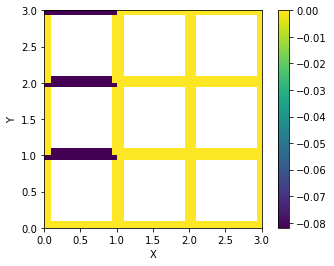

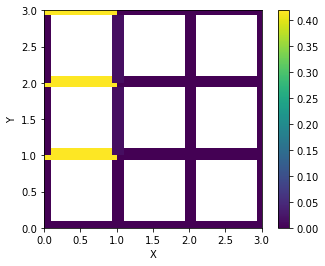

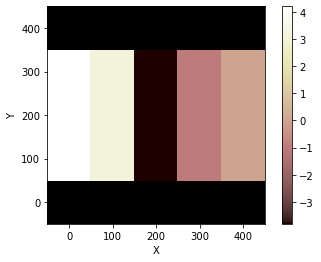

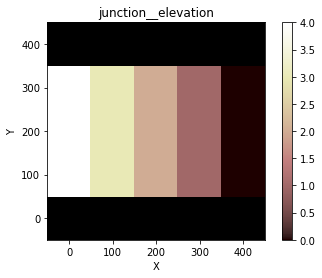

In [14]:
figure()
plot_links(mg, 'conduit__discharge')
figure()
plot_links(mg, 'hydraulic__diameter')
figure()
imshow_grid_at_node(mg, h)
figure()
imshow_grid_at_node(mg, 'junction__elevation')


In [6]:
FUDGE=0.0001
active_links = mg.active_links
head_nodes = mg.node_at_link_head[active_links]
tail_nodes = mg.node_at_link_tail[active_links]
h_head = mg.at_node['hydraulic__head'][head_nodes]
h_tail = mg.at_node['hydraulic__head'][tail_nodes]
#Calculate flow depths using offset and junction elevations
y_head = h_head - mg.at_node['junction__elevation'][head_nodes] \
         - mg.at_link['conduit_head__offset'][active_links]
y_tail = h_tail - mg.at_node['junction__elevation'][tail_nodes] \
          - mg.at_link['conduit_tail__offset'][active_links]
y_head[y_head>mg.at_link['maximum__depth'][active_links]] = mg.at_link['maximum__depth'][active_links][y_head>mg.at_link['maximum__depth'][active_links]]
y_tail[y_tail>mg.at_link['maximum__depth'][active_links]] = mg.at_link['maximum__depth'][active_links][y_tail>mg.at_link['maximum__depth'][active_links]]
y_avg = 0.5*(y_head + y_tail)
A_avg = mg.at_link['width'][active_links] * y_avg
y_avg[y_avg<FUDGE] = FUDGE
A_avg[A_avg<FUDGE] = FUDGE

In [7]:
y_head

array([-3.49693529, -2.99999887, -2.49938704,  0.        , -3.49693529,
       -2.99999887, -2.49938704, -3.49693529, -2.99999887, -2.49938704,
        0.        , -3.49693529, -2.99999887, -2.49938704, -3.49693529,
       -2.99999887, -2.49938704,  0.        ])

In [22]:
#y_tail[y_tail>mg.at_link['maximum__depth'][active_links]] = 
#mg.at_link['maximum__depth'][active_links][y_tail>mg.at_link['maximum__depth'][active_links]]
d_h_square(mg.at_link['width'][active_links], y_avg)

array([  3.96936126e-01,   3.53636005e-04,   3.99594057e-04,
         3.99687423e-04,   3.99814040e-04,   3.99715864e-04,
         3.99694894e-04,   4.90132384e-01,   3.99793756e-04,
         3.96927434e-04,   3.99777355e-04,   3.99802869e-04,
         3.99787176e-04,   3.97200621e-04,   2.81319838e-01,
         3.99646193e-04,   3.99446218e-04,   3.99054260e-04])

In [21]:
def d_h_square(width, flow_depth):
    d_H = np.zeros(np.size(width))
    is_full_pipe = np.isclose(width,flow_depth)
    d_H[is_full_pipe] = width[is_full_pipe]
    d_H[~is_full_pipe] = 4.*width[~is_full_pipe]*flow_depth[~is_full_pipe] / (2.*flow_depth[~is_full_pipe] + width[~is_full_pipe])
    return d_H

In [17]:
mg.at_link['hydraulic__diameter'][mg.active_links]

array([ 0.75,  0.75,  0.75,  0.5 ,  0.75,  0.75,  0.75,  0.75,  0.75,
        0.75,  0.5 ,  0.75,  0.75,  0.75,  0.75,  0.75,  0.75,  0.5 ])

In [11]:
pfn.run_one_step()

Number of iterations = 1 tolerance = nan  iteration time= 0.016219377517700195


/home/mcoving/Data/github/landlab/landlab/components/conduit_networks/pressurized_flow.py:186: RuntimeWarning: divide by zero encountered in true_divide
  self.r = 8*f*L/(g*r_s**2.*d_h**5.)
/home/mcoving/Data/github/landlab/landlab/components/conduit_networks/pressurized_flow.py:267: RuntimeWarning: divide by zero encountered in double_scalars
  ADA_ij[i][j] = -1./(a[this_link]*r[this_link]*np.fabs(self.Q[this_link])**(a[this_link]-1))
/home/mcoving/anaconda3/envs/landlab_dev/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:198: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
/home/mcoving/Data/github/landlab/landlab/components/conduit_networks/pressurized_flow.py:277: RuntimeWarning: divide by zero encountered in true_divide
  dQ= -(1./a[self.grid.active_links])*self.Q[self.grid.active_links] - 1./(a[self.grid.active_links]*r[self.grid.active_links]*np.fabs(self.Q[self.grid.active_links])**(a[self.grid.active_link

In [5]:
d_h.copy()

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [54]:
mg.at_node['junction__elevation']

array([ 4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,
        1.,  0.,  4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,  1.,  0.])